Есть два набора данных (во вложении): визиты пользователей на сервис и данные по покупкам. У каждого визита есть источник, а также устройство, с которого заходил пользователь.
```
Файл: purchases – покупки. 
Файл: visits – визиты.
```
```
Обозначения в файлах:
start_dt — дата старта визита,
start_ts — дата и время старта визита,
end_ts — дата окончания визита,
uid — идентификатор пользователя,
source_id — id источника визита,
device — устройство,
buy_ts — дата и время покупки,
revenue — доход в y.e.
```
```
Необходимо определить:

1)	Какая когорта пользователей (по месяцу первой покупки) принесла наибольший средний чек на пользователя, какая наименьший.
2)	Какие аномалии в трафике видите, если они есть.
3)	Какой LTV на каждую когорту пользователей (по месяцу первой покупки)?
4)	С какого source_id мы получили больший доход помесячно, учитывая, что покупку относим к id источника последнего перед покупкой визита.
```

Просьба написать sql-запросы и визуализировать данные с помощью любого инструмента.


In [89]:
import pandas as pd
import plotly_express as px
from statsmodels.tsa.seasonal import STL

In [90]:
df1p = pd.read_excel('Источники переделанные в excel/purchases.xlsx')
df2v = pd.read_excel('Источники переделанные в excel/visits.xlsx')

In [91]:
#Просмотр типов данных: 
df1p.info()
df2v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75716 entries, 0 to 75715
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   75716 non-null  datetime64[ns]
 1   uid      75716 non-null  int64         
 2   revenue  75716 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720679 entries, 0 to 720678
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     720679 non-null  object        
 1   end_ts     720679 non-null  object        
 2   source_id  720679 non-null  int64         
 3   start_dt   720679 non-null  datetime64[ns]
 4   start_ts   720679 non-null  object        
 5   uid        720679 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 33.0+ MB


In [92]:
#Просмотр дат в визитах:
df2v.head()

,device,end_ts,source_id,start_dt,start_ts,uid
0,desktop,2016-11-30T11:04:17Z,2,2016-11-30,2016-11-30T10:53:49Z,3758486201
1,desktop,2016-11-10T23:16:57Z,4,2016-11-10,2016-11-10T23:08:04Z,2933941628
2,desktop,2016-10-19T18:51:56Z,1,2016-10-19,2016-10-19T18:48:16Z,1465872791
3,desktop,2017-01-12T20:51:55Z,9,2017-01-12,2017-01-12T20:50:10Z,2751875787
4,touch,2016-07-23T19:17:19Z,4,2016-07-23,2016-07-23T19:10:57Z,3492372810


In [93]:
#Форматирование к одному формату даты: 

df2v['start_ts'] = pd.to_datetime(df2v['start_ts'])
df2v['end_ts'] = pd.to_datetime(df2v['end_ts'])

In [94]:
#Просмотр типов данных: 
df1p.info()
df2v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75716 entries, 0 to 75715
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   75716 non-null  datetime64[ns]
 1   uid      75716 non-null  int64         
 2   revenue  75716 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720679 entries, 0 to 720678
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   device     720679 non-null  object             
 1   end_ts     720679 non-null  datetime64[ns, UTC]
 2   source_id  720679 non-null  int64              
 3   start_dt   720679 non-null  datetime64[ns]     
 4   start_ts   720679 non-null  datetime64[ns, UTC]
 5   uid        720679 non-null  int64              
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), int64(2), obj

In [95]:
#Просмотр дат в визитах:
df2v.head()

,device,end_ts,source_id,start_dt,start_ts,uid
0,desktop,2016-11-30 11:04:17+00:00,2,2016-11-30,2016-11-30 10:53:49+00:00,3758486201
1,desktop,2016-11-10 23:16:57+00:00,4,2016-11-10,2016-11-10 23:08:04+00:00,2933941628
2,desktop,2016-10-19 18:51:56+00:00,1,2016-10-19,2016-10-19 18:48:16+00:00,1465872791
3,desktop,2017-01-12 20:51:55+00:00,9,2017-01-12,2017-01-12 20:50:10+00:00,2751875787
4,touch,2016-07-23 19:17:19+00:00,4,2016-07-23,2016-07-23 19:10:57+00:00,3492372810


In [96]:
# Общая статистика, пропущенные значения и дубликаты.

print('Покупки, пропущенные значения', df1p.isnull().sum())
print('Визиты, пропущенные значения', df2v.isnull().sum())
print('Покупки, дубликаты', df1p.duplicated().sum())
print('Визиты, дубликаты', df2v.duplicated().sum())

Покупки, пропущенные значения buy_ts     0
uid        0
revenue    0
dtype: int64
Визиты, пропущенные значения device       0
end_ts       0
source_id    0
start_dt     0
start_ts     0
uid          0
dtype: int64
Покупки, дубликаты 0
Визиты, дубликаты 0


In [97]:
#Данные до Join:
print('Покупки', df1p.shape)
print('Визиты', df2v.shape)

Покупки (75716, 3)
Визиты (720679, 6)


In [98]:
#Join файлов:
table1 = pd.merge(df1p, df2v, on='uid', how='left')

In [99]:
#Проверка после Join:
print('Покупки/Визиты, пропущенные значения:', table1.isnull().sum())
print('Покупки/Визиты, дубликаты:', table1.duplicated().sum())

#Проверка после Join:
buyDO = print('Исходных покупок:', df1p.shape[0])
buyPosle = print('Уникальных покупок после джоина:', table1.groupby(['uid', 'buy_ts']).ngroups)

#Данные после Join:
print('Количество строк table1 после Join:', table1.shape)

#Join работает корректно если buyPosle = buyDO (Количество строк и там и там).

print('Join корректен:', buyDO == buyPosle)

Покупки/Визиты, пропущенные значения: buy_ts       0
uid          0
revenue      0
device       0
end_ts       0
source_id    0
start_dt     0
start_ts     0
dtype: int64
Покупки/Визиты, дубликаты: 0
Исходных покупок: 75716
Уникальных покупок после джоина: 75716
Количество строк table1 после Join: (5325086, 8)
Join корректен: True


Приступаем к первой задаче:
```
1)	Какая когорта пользователей (по месяцу первой покупки) принесла наибольший средний чек на пользователя, какая наименьший.

```

Подготовка к когортному анализу:

In [100]:
#Шаг 1. Найти первую покупку каждого покупателя (получить даты первых покупок для когорт). 

first_buy = table1.groupby('uid')['buy_ts'].min().reset_index()
first_buy.head()

,uid,buy_ts
0,157352,2016-06-23 13:08:21
1,256370,2016-06-13 18:07:53
2,308857,2016-06-23 09:07:29
3,352142,2017-02-17 18:41:06
4,445960,2016-10-19 13:28:03


In [101]:
#Шаг 2. Переделываем даты в месяцы (когорты).

first_buy['cohort_month'] = first_buy['buy_ts'].dt.to_period('M')

In [102]:
#Шаг 3. Присоединяем  когорты (месяцы) к каждой покупке.

table1_cohort = table1.merge(first_buy[['uid', 'cohort_month']], on='uid')

#Выводим, чтобы просмотреть:
table1_cohort.head()

,buy_ts,uid,revenue,device,end_ts,source_id,start_dt,start_ts,cohort_month
0,2016-07-23 19:13:54,3492372810,1.47,touch,2016-07-23 19:17:19+00:00,4,2016-07-23,2016-07-23 19:10:57+00:00,2016-07
1,2016-07-23 19:13:54,3492372810,1.47,desktop,2017-04-18 15:24:04+00:00,1,2017-04-18,2017-04-18 15:17:26+00:00,2016-07
2,2016-11-06 02:48:27,1564753091,1.11,desktop,2016-11-06 02:54:57+00:00,5,2016-11-06,2016-11-06 02:38:06+00:00,2016-11
3,2016-11-06 02:48:27,1564753091,1.11,desktop,2016-11-06 01:43:14+00:00,5,2016-11-06,2016-11-06 01:25:11+00:00,2016-11
4,2016-11-06 02:48:27,1564753091,1.11,desktop,2016-11-24 14:56:23+00:00,9,2016-11-24,2016-11-24 14:53:35+00:00,2016-11


Когортный анализ: 

In [103]:
#Шаг 1. Группируем по когорте и пользователю, считаем общий доход:


#Сумма выручки по user:
user_renevue = table1_cohort.groupby(['cohort_month', 'uid'])['revenue'].sum().reset_index()

#Средняя выручка по когортам:
cohort_avg_renevue = user_renevue.groupby('cohort_month')['revenue'].mean().sort_values(ascending=False)

print('test:', cohort_avg_renevue)

test: cohort_month
2016-06    9005.433542
2016-09     900.663934
2016-08     580.072637
2016-07     410.136413
2017-03     198.301141
2016-11     143.419334
2016-12      93.084708
2017-01      79.505334
2016-10      65.718453
2017-04      56.236267
2017-02      35.148529
2017-06      17.595000
2017-05      16.761125
Freq: M, Name: revenue, dtype: float64


In [104]:
#Шаг 2. Определяем какая когорта пользователей (по месяцу первой покупки) принесла наибольший средний чек на пользователя, какая наименьший.

WIN_cohort = cohort_avg_renevue.idxmax()
LOSE_cohort = cohort_avg_renevue.idxmin()

print('Лучшая когорта:', WIN_cohort,':','Когорты AVG Выручка:', cohort_avg_renevue.max())
print('Худшая когорта:', LOSE_cohort,':','Когорты AVG Выручка:', cohort_avg_renevue.min())

Лучшая когорта: 2016-06 : Когорты AVG Выручка: 9005.43354231975
Худшая когорта: 2017-05 : Когорты AVG Выручка: 16.761124943413307


Приступаем ко второй задаче: 
```
2)	Какие аномалии в трафике видите, если они есть.
```

Аномалии в трафике:

In [105]:
#Выводим информацию о таблице:
table1_cohort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5325086 entries, 0 to 5325085
Data columns (total 9 columns):
 #   Column        Dtype              
---  ------        -----              
 0   buy_ts        datetime64[ns]     
 1   uid           int64              
 2   revenue       float64            
 3   device        object             
 4   end_ts        datetime64[ns, UTC]
 5   source_id     int64              
 6   start_dt      datetime64[ns]     
 7   start_ts      datetime64[ns, UTC]
 8   cohort_month  period[M]          
dtypes: datetime64[ns, UTC](2), datetime64[ns](2), float64(1), int64(2), object(1), period[M](1)
memory usage: 365.6+ MB


In [106]:
#Напоминаем себе о структуре таблицы:
table1_cohort.head()

,buy_ts,uid,revenue,device,end_ts,source_id,start_dt,start_ts,cohort_month
0,2016-07-23 19:13:54,3492372810,1.47,touch,2016-07-23 19:17:19+00:00,4,2016-07-23,2016-07-23 19:10:57+00:00,2016-07
1,2016-07-23 19:13:54,3492372810,1.47,desktop,2017-04-18 15:24:04+00:00,1,2017-04-18,2017-04-18 15:17:26+00:00,2016-07
2,2016-11-06 02:48:27,1564753091,1.11,desktop,2016-11-06 02:54:57+00:00,5,2016-11-06,2016-11-06 02:38:06+00:00,2016-11
3,2016-11-06 02:48:27,1564753091,1.11,desktop,2016-11-06 01:43:14+00:00,5,2016-11-06,2016-11-06 01:25:11+00:00,2016-11
4,2016-11-06 02:48:27,1564753091,1.11,desktop,2016-11-24 14:56:23+00:00,9,2016-11-24,2016-11-24 14:53:35+00:00,2016-11


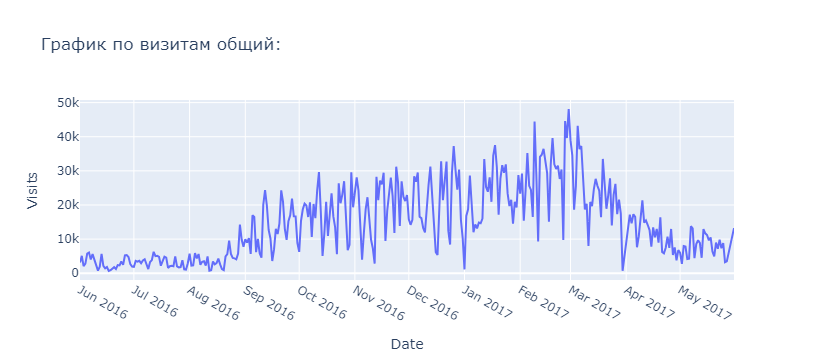

In [123]:
#Выведем сначала график для наглядности:

visits = table1_cohort.groupby('start_dt').size().reset_index()
visits.columns = ['Date', 'Visits']
fig = px.line(visits, x='Date', y='Visits', title='График по визитам общий:')
fig.update_xaxes(dtick="M1")
fig.show()
fig.write_image("plot1.png")

![График](my_plot1.png)

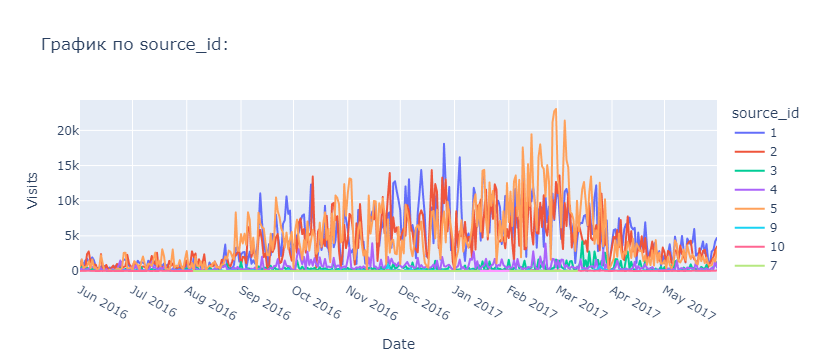

In [124]:
#Выведем график для наглядности по источникам:

visitsS = table1_cohort.groupby(['start_dt', 'source_id']).size().reset_index()
visitsS.columns = ['Date', 'source_id', 'Visits']  # Исправлено: 3 имени для 3 столбцов
fig = px.line(visitsS, x='Date', y='Visits', color='source_id', title='График по source_id:')  # Добавлен color='source_id'
fig.update_xaxes(dtick="M1")
fig.show()
fig.write_image("plot2.png")

In [109]:
![График](my_plot2.png)

"[ѓа дЁЄ]" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Перед началом анализа на аномалии, запишем вводные и несколько гипотез:
```
Вводные:
-У нас два входа по device: desktop/touch.
-У нас несколько id источника визита (от 1 до 10).
-У нас start_ts — дата и время старта визита(как доп. start_dt — дата старта визита), 
       end_ts — дата окончания визита.
-У нас есть buy_ts — дата и время покупки.
```
```
Гипотезы:
-Появления приложения, предположим, что это touch, повысило трафик.
-Влияние сезонности на прирост или отток трафика, по текущим данным(Cезонность, праздничные дни и др.).
-Несколько ключевых источника обеспечивают большую часть общего тренда (в Росте) трафика, значительно опережая остальные. 
```

Сначала поймем, что такое аномальный трафик, тут:

-Используем метод "процентили", также выведем нижнюю и верхнюю границу трафика. 

(Ранее я уже прогнал: STL + z_score, IQR. Как по мне "Процентили" самый быстры эффективный и простой метод тут, чтобы просмотреть основные моменты, которые +- видишь уже "Глазом"). 

In [110]:
#Группируем данные:
visits = table1_cohort.groupby('start_dt').size().reset_index()
visits.columns = ['Date', 'Visits']

# Находим процентили (например, 5% и 95%)
lower_bound = visits['Visits'].quantile(0.05)
upper_bound = visits['Visits'].quantile(0.95)

print(lower_bound)
print(upper_bound)

1821.1
33421.29999999998


Аномальный трафик тут, по нашему методу, это все, что:
```
Меньше Нижней границы(lower_bound) значения: 1821.1 .
Больше Верхней границы(upper_bound) значения: 33421.29999999998 .

Перейдем к нашим гипотезам:
```
Гипотеза 1:

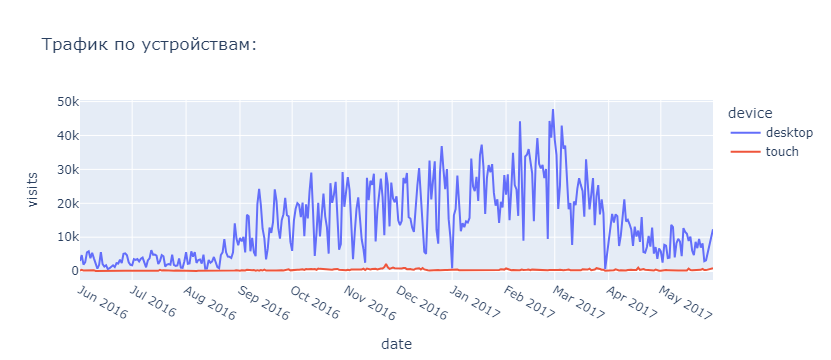

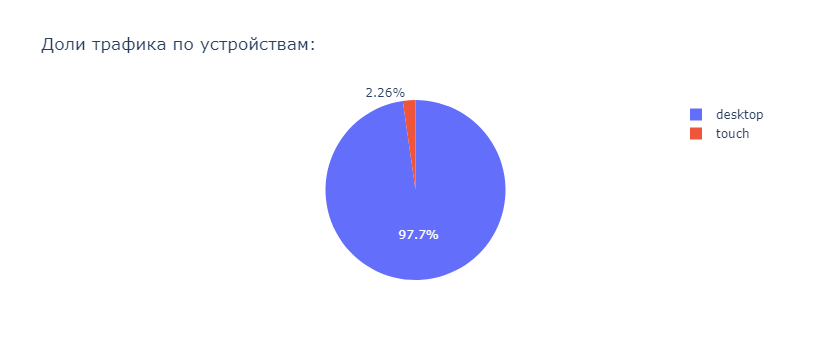

In [125]:
#Появления приложения,touch, повысило трафик.

visitsTouch = table1_cohort.groupby(['start_dt', 'device']).size().reset_index(name='visits')
visitsTouch.columns = ['date', 'device', 'visits']
fig = px.line(visitsTouch, x='date', y='visits', color='device', title='Трафик по устройствам:')
fig.update_xaxes(dtick="M1")
fig.show()
fig.write_image("plot3.png")
# График долей через пирог
total_by_device = visitsTouch.groupby('device')['visits'].sum().reset_index()
fig_pie = px.pie(total_by_device, values='visits', names='device', 
                title='Доли трафика по устройствам:',
                color='device')
fig_pie.show()
fig_pie.write_image("plot4.png")

In [112]:
![График](my_plot3.png)

"[ѓа дЁЄ]" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [113]:
![График](my_plot4.png)

"[ѓа дЁЄ]" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Как видим по графику, проверяя гипотезу "Появления приложения, предположим, что это touch, повысило трафик.". 

Вывод: Доля трафика с touch минимальная. Нет влияния. 

Гипотеза 2:

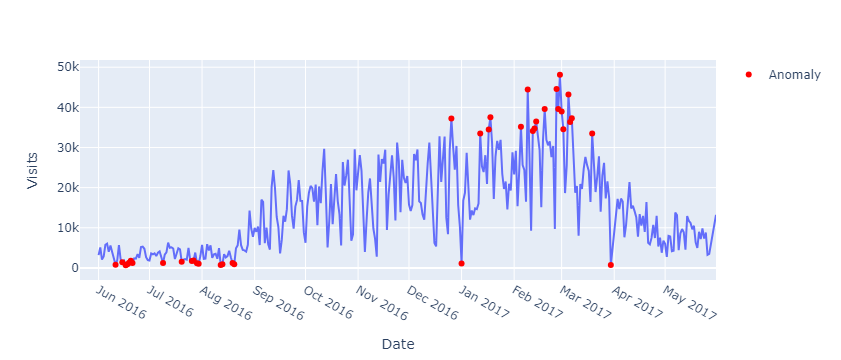

In [114]:
#Влияние сезонности на прирост или отток трафика, по текущим данным(Cезонность, праздничные дни и др.):

# Аномалии
anomal = visits[(visits['Visits'] < lower_bound) | (visits['Visits'] > upper_bound)]

fig = px.line(visits, x='Date', y='Visits')
fig.add_scatter(x=anomal['Date'], y=anomal['Visits'], 
                mode='markers', marker_color='red', name='Anomaly')
fig.update_xaxes(dtick="M1")
fig.show()

In [115]:
![График](my_plot5.png)

"[ѓа дЁЄ]" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [116]:
print('Даты аномалий: Пиковые/Минимальные:', anomal.sort_values('Date').to_string(index=False))

Даты аномалий: Пиковые/Минимальные:       Date  Visits
2016-06-11     779
2016-06-15    1420
2016-06-17     656
2016-06-18     906
2016-06-19    1268
2016-06-20    1792
2016-06-21    1232
2016-07-09    1206
2016-07-20    1554
2016-07-26    1717
2016-07-27    1820
2016-07-29    1137
2016-07-30    1048
2016-08-12     737
2016-08-13     904
2016-08-19    1231
2016-08-20     932
2016-12-26   37243
2017-01-01    1120
2017-01-12   33490
2017-01-17   34459
2017-01-18   37541
2017-02-05   35192
2017-02-09   44450
2017-02-12   34115
2017-02-13   34736
2017-02-14   36447
2017-02-19   39589
2017-02-26   44590
2017-02-27   39608
2017-02-28   48124
2017-03-01   38997
2017-03-02   34570
2017-03-05   43204
2017-03-06   36367
2017-03-07   37300
2017-03-19   33490
2017-03-30     703


Выводы по гипотезе "Влияние сезонности на прирост или отток трафика, по текущим данным(Cезонность, праздничные дни и др.)."

*Под аномалией имею ввиду минимальное/максимальное значения трафика по методу "Процентили". 
```
Cезонность, общий тренд: Ближе к наступлении осени трафик начинает активно расти. C наступлением весны, снижение.

Праздники: тренд формировался на снижение c 29 декабря по 1 января, видим явную аномалию относящиеся, к "праздиники", по снижнею трафика. Далее активный рост, обратный тренд начиная с 10-11 чисел январа, достигая пиковых значений 12-го.

Также на графике есть аномалии, которые не совсем характерны праздникам, и до конца влиянием сезонности, их нужно отдельно изучать. 
```
Вывод: Влияение есть. 

Гипотеза 3:

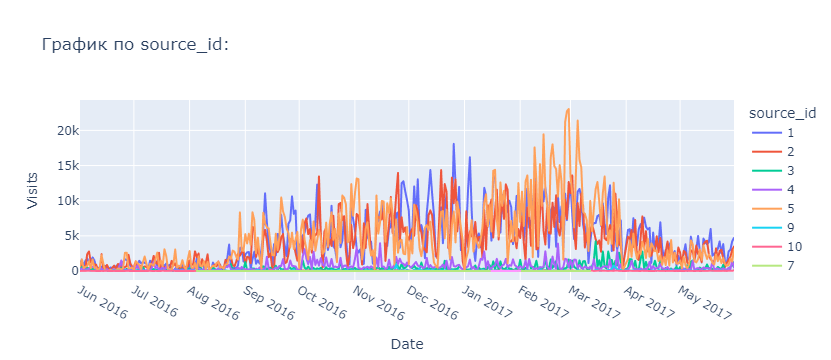

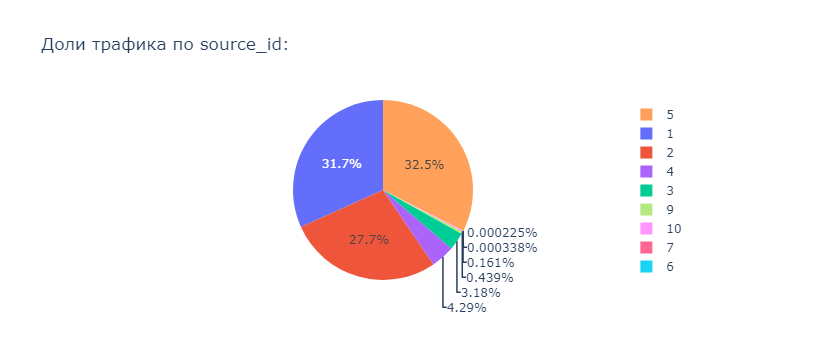

In [117]:
#Несколько ключевых источника обеспечивают большую часть общего тренда (в Росте) трафика, значительно опережая остальные.

visitsS = table1_cohort.groupby(['start_dt', 'source_id']).size().reset_index()
visitsS.columns = ['Date', 'source_id', 'Visits']  # Исправлено: 3 имени для 3 столбцов
fig = px.line(visitsS, x='Date', y='Visits', color='source_id', title='График по source_id:')  # Добавлен color='source_id'
fig.update_xaxes(dtick="M1")
fig.show()

# График долей через пирог с теми же цветами
total_by_source = visitsS.groupby('source_id')['Visits'].sum().reset_index()
fig_pie = px.pie(total_by_source, values='Visits', names='source_id', 
                 title='Доли трафика по source_id:',
                 color='source_id')  # Добавляем color='source_id'
fig_pie.show()

In [118]:
![График](my_plot6.png)

"[ѓа дЁЄ]" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Выводы по гипотезе "Несколько ключевых источников обеспечивают большую часть общего тренда (в Росте) трафика, значительно опережая остальные.".

Вывод: Влияние 1,2,5 источников больше, чем остальных. Влияние подтверждено. 

Приступаем к третьей задаче: 
```
3)	Какой LTV на каждую когорту пользователей (по месяцу первой покупки)?
```

In [120]:
#Подсчет LTV на каждую когорту пользователей (по месяцу первой покупки):

#Группируем данные и суммируем: 
ltv_by_cohort = table1_cohort.groupby('cohort_month')['revenue'].sum().reset_index()

#Измен. имя revenue на ltv. 
ltv_by_cohort.columns = ['cohort_month', 'ltv']

#Выводим:
print(ltv_by_cohort) 

   cohort_month          ltv
0       2016-06  31600066.30
1       2016-07   1262399.88
2       2016-08   1295882.27
3       2016-09   3665702.21
4       2016-10    442350.91
5       2016-11    872132.97
6       2016-12    612125.04
7       2017-01    402137.98
8       2017-02    191629.78
9       2017-03   1033743.85
10      2017-04    189516.22
11      2017-05     74050.65
12      2017-06        70.38


Приступаем к четвёртой задаче:
```
4)	С какого source_id мы получили больший доход помесячно, учитывая, что покупку относим к id источника последнего перед покупкой визита.
```

Я пробывал по разному, но эту задачу мой компьютер (Pandas-скрипт не тянет :D). 
```
Поэтому вот SQL-запрос: 

    -- Выбираем только покупки
WITH purchases AS (
    SELECT 
        uid,
        buy_ts,
        revenue,
        DATE_TRUNC('month', buy_ts) AS buy_month
        --DATE_TRUNC - месяц покупки. Обрезаем. 
    FROM purchases  
    WHERE buy_ts IS NOT NULL
),
  -- Выбираем только визиты
visits AS (
    SELECT 
        uid,
        start_ts,
        source_id
    FROM visits  
),
  -- Для каждой покупки находим последний визит
  --Для каждой покупки (PARTITION BY uid, buy_ts) создается отдельная группа
Визиты сортируются по времени (ORDER BY start_ts DESC)
Последний визит получает номер 1, предпоследний - 2, и т.д.
last_visit_per_purchase AS (
    SELECT 
        p.buy_month,
        p.revenue,
        v.source_id,
        -- Ранжируем визиты по времени для каждой покупки
        ROW_NUMBER() OVER (
            PARTITION BY p.uid, p.buy_ts 
            ORDER BY v.start_ts DESC
        ) AS visit_rank
    FROM purchases p
    INNER JOIN visits v ON p.uid = v.uid AND v.start_ts < p.buy_ts
),
    -- Берем только последний визит (rank = 1)
purchases_with_source AS (
    SELECT 
        buy_month,
        source_id,
        revenue
    FROM last_visit_per_purchase
    WHERE visit_rank = 1
),
   -- Суммируем доходы по месяцам и источникам
monthly_totals AS (
    SELECT 
        buy_month,
        source_id,
        SUM(revenue) AS total_revenue,
        ROW_NUMBER() OVER (
            PARTITION BY buy_month 
            ORDER BY SUM(revenue) DESC
        ) AS rank
    FROM purchases_with_source
    GROUP BY buy_month, source_id
)

-- Итоговый результат
SELECT 
    buy_month,
    source_id,
    total_revenue AS revenue
FROM monthly_totals
WHERE rank = 1
ORDER BY buy_month;
```